# Assessing Quality of Nighttime Lights Data

### Overview <a name="overview"></a>

The quality of nighttime lights data can be impacted by a number of factors, particularly cloud cover. To facilitate analysis using high quality data, Black Marble (1) marks the quality of each pixel and (2) in some cases of poor quality pixels, Black Marble will use data from a previous date to fill the value---using a temporally-gap filled NTL value. 

Below we illustrate how to examine the quality of nighttime lights data.

* [Setup](#setup)
* [Daily data](#daily)
    * [Nighttime lights](#daily-ntl)
    * [Quality flag](#daily-quality)
    * [Nighttime lights using good quality observations](#daily-goodq)
    * [Nighttime lights using good quality observations without gap filling](#daily-nogap)
* [Monthly/annual data](#ma)
    * [Nighttime lights](#ma-ntl)
    * [Number of observations](#ma-numobs)
    * [Quality](#ma-quality)
    * [Nighttime lights using good quality observations](#ma-ntl_gq)

### Setup <a name="setup"></a>

We first load packages and obtain a polygon for a region of interest; for this example, we use Switzerland. 

In [2]:
import datetime
import glob
import os
import time

import geopandas as gpd
import colorcet as cc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
import seaborn as sns
from gadm import GADMDownloader
from rasterstats import zonal_stats

from blackmarble.bm_extract import bm_extract
from blackmarble.bm_raster import bm_raster

/Users/robmarty/opt/anaconda3/envs/jupyterlab/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
bearer = os.getenv("BLACKMARBLE_TOKEN")
bearer = pd.read_csv("/Users/robmarty/Desktop/bearer_bm.csv")["token"][0]

In [4]:
gdf = GADMDownloader(version="4.0").get_shape_data_by_country_name(
    country_name="Switzerland", ad_level=0
)

### Daily Data <a name="daily"></a>

Below shows an example examining quality for daily data (`VNP46A2`).

#### Nighttime Lights <a name="daily-ntl"></a>

We download data for January 1st, 2023. When the `variable` parameter is not specified, `bm_raster` creates a raster using the `Gap_Filled_DNB_BRDF-Corrected_NTL` variable for daily data.

In [5]:
ntl_r = bm_raster(roi_sf = gdf,
                  product_id = "VNP46A2",
                  date = "2023-01-01",
                  bearer = bearer,
                  variable = "Gap_Filled_DNB_BRDF-Corrected_NTL")

  0%|          | 0/2 [00:00<?, ?it/s]
  0%|          | 0.00/5.22M [00:00<?, ?B/s]
Processing VNP46A2.A2023001.h18v04.001.2023012014505.h5...:   0%|          | 0.00/5.22M [00:00<?, ?B/s]
Processing VNP46A2.A2023001.h18v04.001.2023012014505.h5...:   8%|▊         | 442k/5.22M [00:00<00:01, 4.39MB/s]
Processing VNP46A2.A2023001.h18v04.001.2023012014505.h5...:  22%|██▏       | 1.13M/5.22M [00:00<00:00, 5.67MB/s]
Processing VNP46A2.A2023001.h18v04.001.2023012014505.h5...:  42%|████▏     | 2.19M/5.22M [00:00<00:00, 7.79MB/s]
Processing VNP46A2.A2023001.h18v04.001.2023012014505.h5...:  69%|██████▉   | 3.62M/5.22M [00:00<00:00, 10.3MB/s]
Processing VNP46A2.A2023001.h18v04.001.2023012014505.h5...:  96%|█████████▌| 5.01M/5.22M [00:00<00:00, 11.5MB/s]
 50%|█████     | 1/2 [00:01<00:01,  1.07s/it]                                                                   
  0%|          | 0.00/5.09M [00:00<?, ?B/s]
Processing VNP46A2.A2023001.h19v04.001.2023012014619.h5...:   0%|          | 0.00/5.09M [00:0

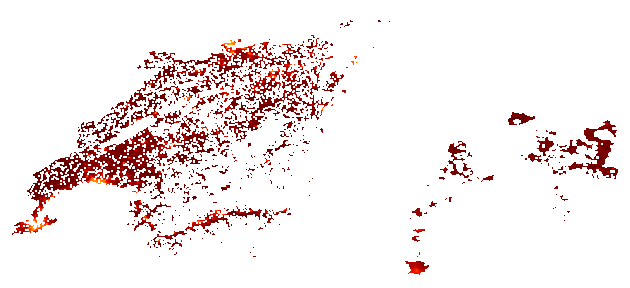

In [6]:
r_np = np.log(ntl_r.read(1))
plt.imshow(r_np, cmap=cc.cm.fire)
plt.axis("off")
plt.tight_layout()

We notice that a number of observations are missing, that are poor quality and are not gap-filled. To understand the extent of missing date, we can use the following code to determine (1) the total number of pixels that cover Switzerland, (2) the total number of non-`NA` nighttime light pixels, and (3) the proportion of non-`NA` pixels.

In [52]:
ntl_np = ntl_r.read(1)

def count_non_nan(arr):
    return np.sum(~np.isnan(arr))
    
n_pixel = zonal_stats(
    gdf,
    ntl_np,
    affine=ntl_r.transform,
    nodata=np.nan,
    masked=False,
    stats=["count", 'nan']
)

In [53]:
## Number of pixels
n_pixel[0]['count'] + n_pixel[0]['nan']

279951.0

In [54]:
## Number of non nan pixels
n_pixel[0]['count']

120725

In [55]:
## Proportion of non nan pixels
n_pixel[0]['count'] / (n_pixel[0]['count'] + n_pixel[0]['nan'])

0.43123618061732233

By default, `bm_extract` computes the mean; we can easily also compute the number of pixels and number of nan pixels.

In [59]:
date_range = (
    pd.date_range(
        datetime.datetime.strptime("2023-01-01", "%Y-%m-%d"),
        datetime.datetime.strptime("2023-01-10", "%Y-%m-%d"),
        freq="D",
    )
    .strftime("%Y-%m-%d")
    .tolist()
)

ntl_df = bm_extract(roi_sf = gdf,
                  product_id = "VNP46A2",
                  date = date_range,
                  bearer = bearer,
                  variable = "Gap_Filled_DNB_BRDF-Corrected_NTL",
                  aggregation_fun = ['mean', 'count', 'nan'])

  0%|          | 0/2 [00:00<?, ?it/s]
  0%|          | 0.00/5.22M [00:00<?, ?B/s]
Processing VNP46A2.A2023001.h18v04.001.2023012014505.h5...:   0%|          | 0.00/5.22M [00:00<?, ?B/s]
Processing VNP46A2.A2023001.h18v04.001.2023012014505.h5...:  11%|█         | 556k/5.22M [00:00<00:00, 5.05MB/s]
Processing VNP46A2.A2023001.h18v04.001.2023012014505.h5...:  27%|██▋       | 1.42M/5.22M [00:00<00:00, 7.10MB/s]
Processing VNP46A2.A2023001.h18v04.001.2023012014505.h5...:  49%|████▉     | 2.56M/5.22M [00:00<00:00, 8.79MB/s]
Processing VNP46A2.A2023001.h18v04.001.2023012014505.h5...:  74%|███████▍  | 3.88M/5.22M [00:00<00:00, 10.5MB/s]
Processing VNP46A2.A2023001.h18v04.001.2023012014505.h5...:  99%|█████████▉| 5.18M/5.22M [00:00<00:00, 11.2MB/s]
 50%|█████     | 1/2 [00:01<00:01,  1.09s/it]                                                                   
  0%|          | 0.00/5.09M [00:00<?, ?B/s]
Processing VNP46A2.A2023001.h19v04.001.2023012014619.h5...:   0%|          | 0.00/5.09M [00:0

In [61]:
ntl_df['prop_non_na_pixels'] = ntl_df['ntl_count'] / (ntl_df['ntl_count'] + ntl_df['ntl_nan'])

In [71]:
ntl_df

,COUNTRY,ID_0,ntl_mean,ntl_count,ntl_nan,date,prop_non_na_pixels
0,Switzerland,CHE,15.122783,120725,159226.0,2023-01-01,0.431236
1,Switzerland,CHE,13.527096,133357,146594.0,2023-01-02,0.476358
2,Switzerland,CHE,6.986185,9772,270167.0,2023-01-03,0.034908
3,Switzerland,CHE,11.345028,125694,154245.0,2023-01-04,0.449005
4,Switzerland,CHE,3.691968,7246,272693.0,2023-01-05,0.025884
5,Switzerland,CHE,11.999496,124882,155069.0,2023-01-06,0.446085
6,Switzerland,CHE,10.214811,88594,191345.0,2023-01-07,0.316476
7,Switzerland,CHE,11.593665,120130,159809.0,2023-01-08,0.429129
8,Switzerland,CHE,16.494204,25621,254330.0,2023-01-09,0.091520
9,Switzerland,CHE,16.810660,41032,238919.0,2023-01-10,0.146569


The below figure shows trends in average nighttime lights (left) and the proportion of the country with a value for nighttime lights (right). For some days, low number of pixels corresponds to low nighttime lights (eg, January 3 and 5th); however, for other days, low number of pixels corresponds to higher nighttime lights (eg, January 9 and 10). On January 3 and 5, missing pixels could have been over typically high-lit areas (eg, cities)---while on January 9 and 10, missing pixels could have been over typically lower-lit areas. 


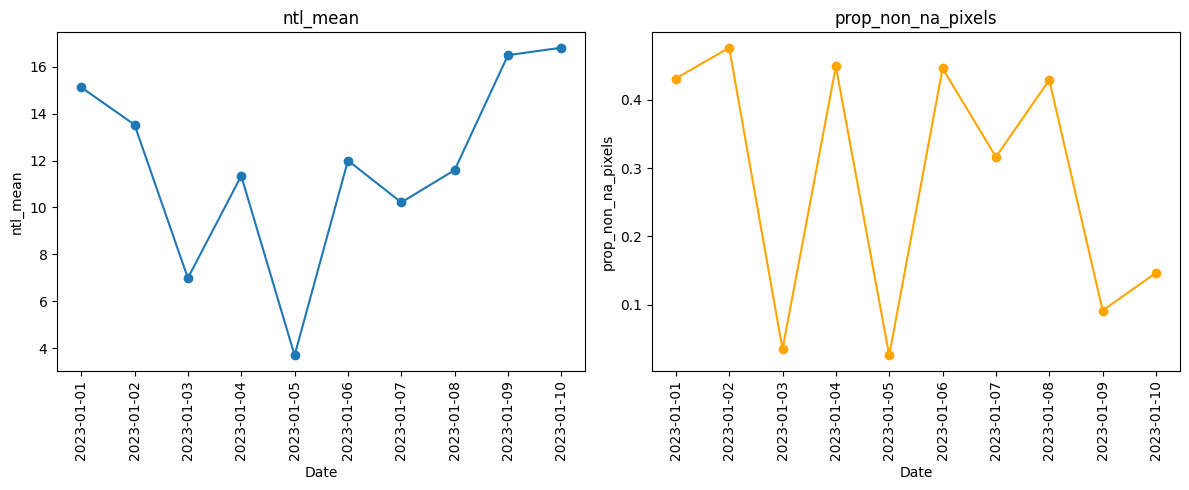

In [70]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns for side-by-side plots

# Left plot (date vs ntl_mean)
axs[0].plot(ntl_df['date'], ntl_df['ntl_mean'], marker='o', linestyle='-')
axs[0].set_title('ntl_mean')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('ntl_mean')
axs[0].tick_params(axis='x', rotation=90)

# Right plot (date vs prop_na)
axs[1].plot(ntl_df['date'], ntl_df['prop_non_na_pixels'], marker='o', linestyle='-', color='orange')
axs[1].set_title('prop_non_na_pixels')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('prop_non_na_pixels')
axs[1].tick_params(axis='x', rotation=90)

# Adjust layout for better spacing
plt.tight_layout()

# Display the plots
plt.show()

#### Quality <a name="daily-quality"></a>

For daily data, the quality values are:

* 0: High-quality, Persistent nighttime lights

* 1: High-quality, Ephemeral nighttime Lights

* 2: Poor-quality, Outlier, potential cloud contamination, or other issues

* 255: No retrieval, Fill value (masked out on ingestion)

We can map quality by using the `Mandatory_Quality_Flag` variable.

In [73]:
quality_r = bm_raster(roi_sf = gdf,
                      product_id = "VNP46A2",
                      date = "2023-01-01",
                      bearer = bearer,
                      variable = "Mandatory_Quality_Flag")

  0%|          | 0/2 [00:00<?, ?it/s]
  0%|          | 0.00/5.22M [00:00<?, ?B/s]
Processing VNP46A2.A2023001.h18v04.001.2023012014505.h5...:   0%|          | 0.00/5.22M [00:00<?, ?B/s]
Processing VNP46A2.A2023001.h18v04.001.2023012014505.h5...:  15%|█▌        | 802k/5.22M [00:00<00:00, 7.97MB/s]
Processing VNP46A2.A2023001.h18v04.001.2023012014505.h5...:  39%|███▉      | 2.05M/5.22M [00:00<00:00, 10.6MB/s]
Processing VNP46A2.A2023001.h18v04.001.2023012014505.h5...:  69%|██████▉   | 3.59M/5.22M [00:00<00:00, 12.8MB/s]
Processing VNP46A2.A2023001.h18v04.001.2023012014505.h5...:  93%|█████████▎| 4.87M/5.22M [00:00<00:00, 12.6MB/s]
 50%|█████     | 1/2 [00:00<00:00,  1.04it/s]                                                                   
  0%|          | 0.00/5.09M [00:00<?, ?B/s]
Processing VNP46A2.A2023001.h19v04.001.2023012014619.h5...:   0%|          | 0.00/5.09M [00:00<?, ?B/s]
Processing VNP46A2.A2023001.h19v04.001.2023012014619.h5...:  24%|██▍       | 1.24M/5.09M [00:00<00:00,